In [2]:
#Required Librraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from fcmeans import FCM
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [16]:
#Dateset Preprocessing
f = pd.read_csv("/home/atik/Desktop/CSE422/spotify.csv")
f.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,in_shazam_charts,bpm,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,826,125,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,382,92,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,949,138,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,548,170,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,425,144,Minor,65,23,80,14,63,11,6


In [4]:
#Dropping Unnecessary Columns 
f = f.drop(['artist_count', 'released_year', 'released_month', 'released_day'], axis = 1)
f.shape


(953, 19)

In [5]:
#Checking the number of 0's and NaN's in each column, then imputing those with mean value
f.isnull().sum()
f['in_shazam_charts'] = f['in_shazam_charts'].str.replace(',', '').astype(float)
imputer = SimpleImputer(strategy='mean')
f['in_shazam_charts'] = imputer.fit_transform(f[['in_shazam_charts']])

In [6]:
f['mode'].unique()

array(['Major', 'Minor'], dtype=object)

In [7]:
# Set up the LabelEncoder object
enc = LabelEncoder()

# Apply the encoding to the "Accessible" column
f['mode_encoded'] = enc.fit_transform(f['mode'])

f = f.drop(['mode'], axis=1)

f.head(5)
f.shape



(953, 19)

We will use 3 unsupervised learning -
K-means Clustering, K-medoids, Fuzzy C-means

Selecting 4 features among the 8 features using PCA for making composite feature

In [8]:
# Define the features
features = ['bpm', 'energy_%', 'acousticness_%', 'liveness_%', 'speechiness_%', 
            'instrumentalness_%' ,'valence_%', 'danceability_%']

# Assume 'f' is your DataFrame containing the data

# Step 1: Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(f[features])

# Step 2: Apply PCA
pca = PCA(n_components=8)  # Choose the number of components you want to select
principal_components = pca.fit_transform(data_scaled)

# Step 3: Select the top principal components
selected_features = pca.inverse_transform(principal_components)

# Convert the array to DataFrame with feature names
selected_features_df = pd.DataFrame(selected_features, columns=features)

# Create a DataFrame to hold the variance explained by each component along with feature names
variance_df = pd.DataFrame({'Feature': features, 'Variance Explained': pca.explained_variance_ratio_})

# Print the DataFrame
print(variance_df)


              Feature  Variance Explained
0                 bpm            0.248066
1            energy_%            0.154478
2      acousticness_%            0.133304
3          liveness_%            0.127049
4       speechiness_%            0.117351
5  instrumentalness_%            0.109265
6           valence_%            0.071681
7      danceability_%            0.038807


Creating Composite Feature

In [9]:
# Create composite features
f['bpm_energy'] = f['bpm'] * f['energy_%']
f['acoustic_liveness'] = f['acousticness_%'] * f['liveness_%']

# Select features for clustering
features = ['bpm_energy', 'acoustic_liveness']
X = f[features]

Funtion for finding optimal value of clusters (how many clusters there will be) with Elbow and Silhouette method

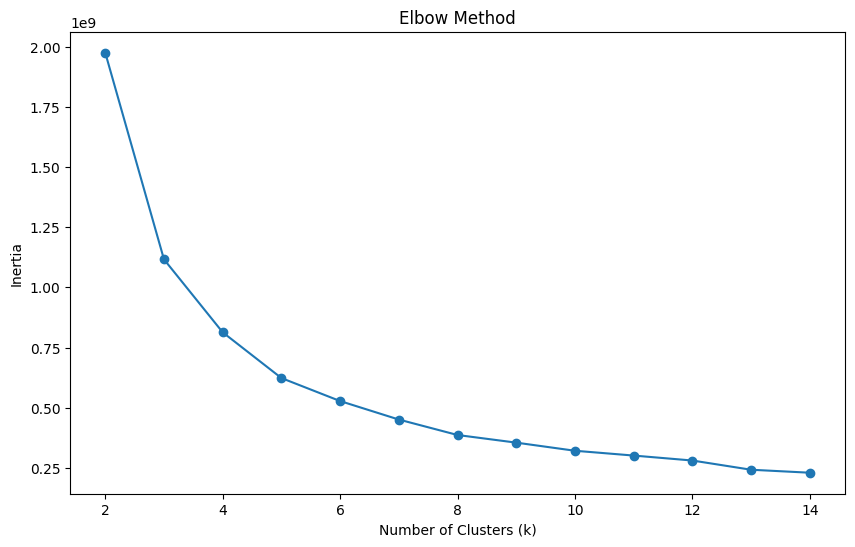

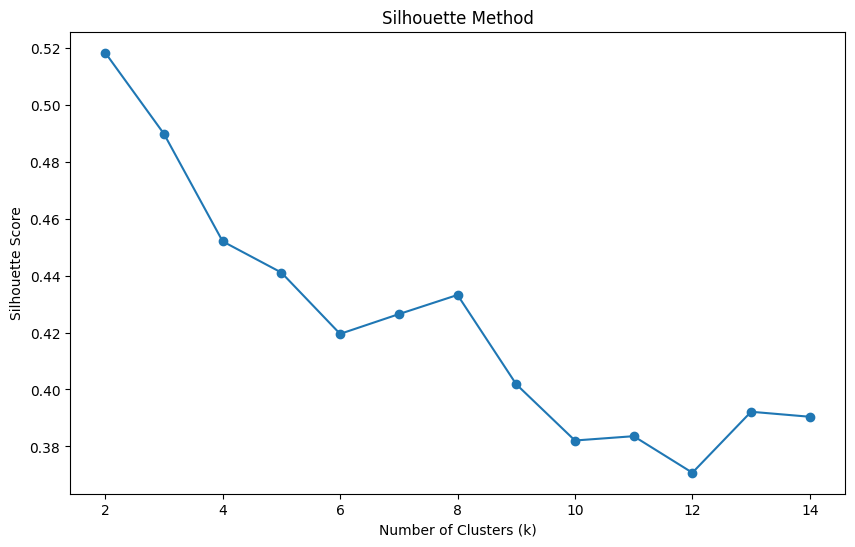

In [10]:
def find_optimal_k_elbow(X, k_range):
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()
    optimal_k = k_range[inertia.index(min(inertia))]
    return optimal_k

def find_optimal_k_silhouette(X, k_range):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import matplotlib.pyplot as plt
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        score = silhouette_score(X, clusters)
        silhouette_scores.append(score)
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.show()
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    return optimal_k

# Split the dataset
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Define the range of k to test
k_range = range(2, 15)

# Call the function for the Elbow method
optimal_k_elbow = find_optimal_k_elbow(X_train, k_range)
# print('Optimal k based on Elbow method:', optimal_k_elbow)

# Call the function for the Silhouette method
optimal_k_silhouette = find_optimal_k_silhouette(X_train, k_range)
# print('Optimal k based on Silhouette method:', optimal_k_silhouette)

Performing K-means Clustering

Silhouette Score before scaling (Training Set): 0.44107408392573316
Silhouette Score before scaling (Testing Set): 0.44331686629709105
Silhouette Score after scaling (Training Set): 0.375697771352107
Silhouette Score after scaling (Testing Set): 0.37360646888569843


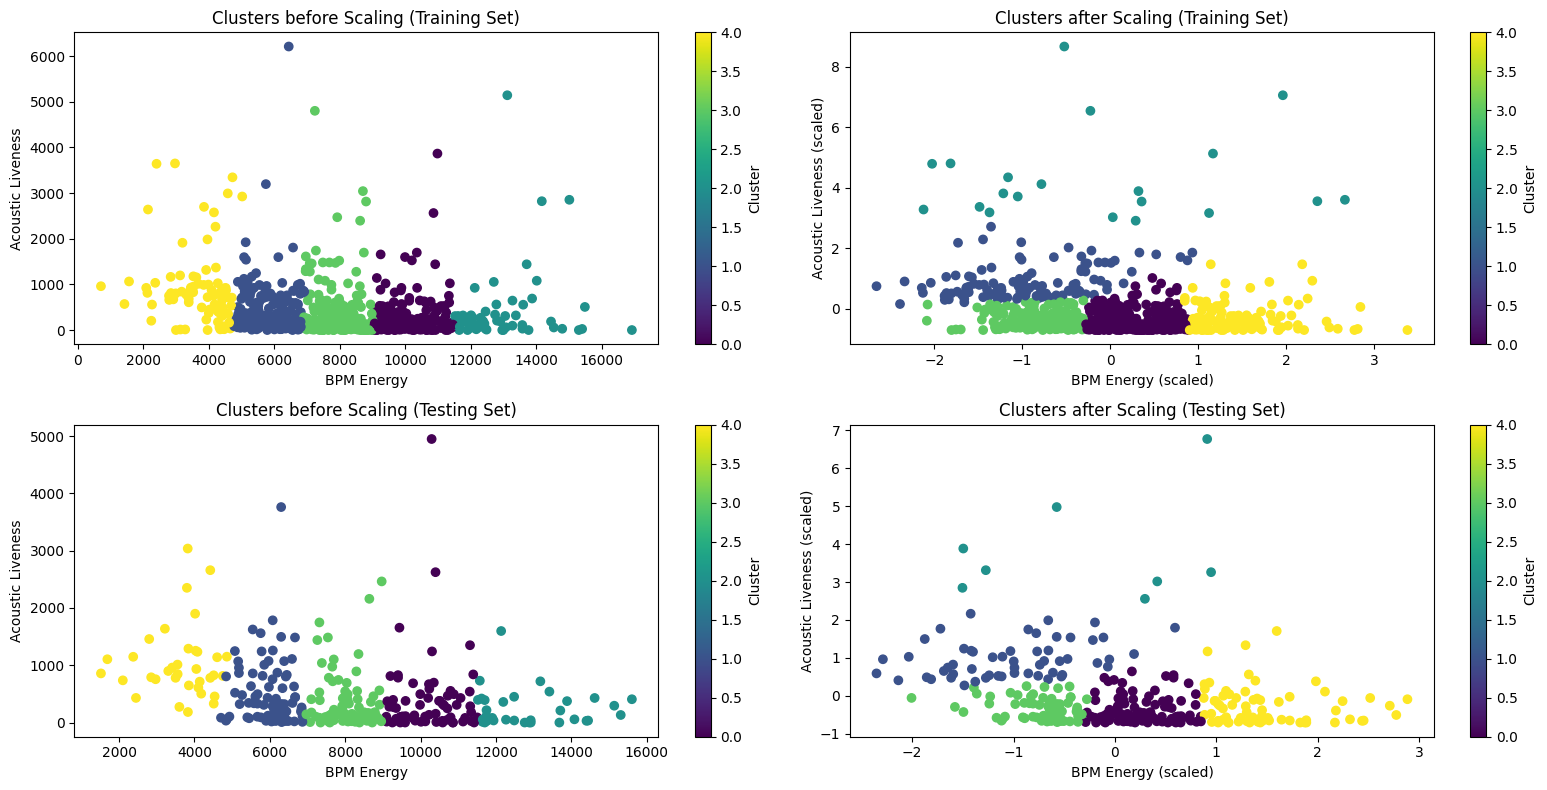

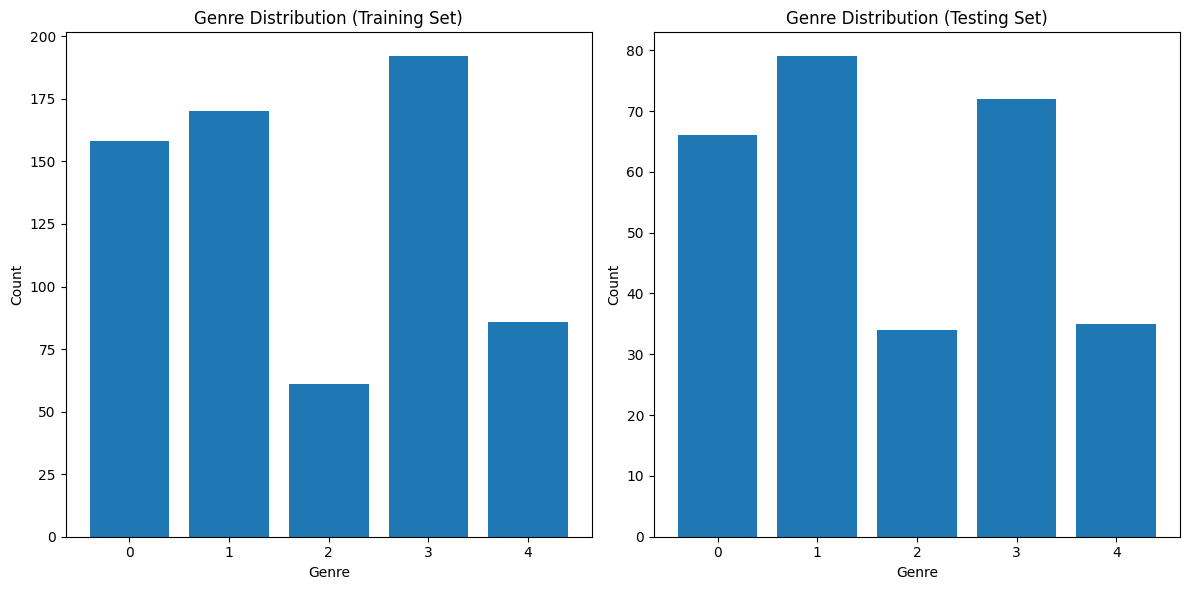

In [11]:
# Assuming X contains your feature matrix and is properly prepared
# Split the dataset into train and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Perform K-means clustering without scaling
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)

# Predict clusters for both training and testing sets
train_clusters = kmeans.predict(X_train)
test_clusters = kmeans.predict(X_test)

# Calculate silhouette scores before scaling
silhouette_train_before = silhouette_score(X_train, train_clusters)
silhouette_test_before = silhouette_score(X_test, test_clusters)
print('Silhouette Score before scaling (Training Set):', silhouette_train_before)
print('Silhouette Score before scaling (Testing Set):', silhouette_test_before)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform K-means clustering with scaling
kmeans_scaled = KMeans(n_clusters=5, random_state=42)
kmeans_scaled.fit(X_train_scaled)

# Predict clusters for both training and testing sets after scaling
train_clusters_scaled = kmeans_scaled.predict(X_train_scaled)
test_clusters_scaled = kmeans_scaled.predict(X_test_scaled)

# Calculate silhouette scores after scaling
silhouette_train_after = silhouette_score(X_train_scaled, train_clusters_scaled)
silhouette_test_after = silhouette_score(X_test_scaled, test_clusters_scaled)
print('Silhouette Score after scaling (Training Set):', silhouette_train_after)
print('Silhouette Score after scaling (Testing Set):', silhouette_test_after)

# Visualization
plt.figure(figsize=(16, 8))

# Clusters before Scaling (Training Set)
plt.subplot(2, 2, 1)
plt.scatter(X_train['bpm_energy'], X_train['acoustic_liveness'], c=train_clusters, cmap='viridis')
plt.title('Clusters before Scaling (Training Set)')
plt.xlabel('BPM Energy')
plt.ylabel('Acoustic Liveness')
plt.colorbar(label='Cluster')

# Clusters after Scaling (Training Set)
plt.subplot(2, 2, 2)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_clusters_scaled, cmap='viridis')
plt.title('Clusters after Scaling (Training Set)')
plt.xlabel('BPM Energy (scaled)')
plt.ylabel('Acoustic Liveness (scaled)')
plt.colorbar(label='Cluster')

# Clusters before Scaling (Testing Set)
plt.subplot(2, 2, 3)
plt.scatter(X_test['bpm_energy'], X_test['acoustic_liveness'], c=test_clusters, cmap='viridis')
plt.title('Clusters before Scaling (Testing Set)')
plt.xlabel('BPM Energy')
plt.ylabel('Acoustic Liveness')
plt.colorbar(label='Cluster')

# Clusters after Scaling (Testing Set)
plt.subplot(2, 2, 4)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_clusters_scaled, cmap='viridis')
plt.title('Clusters after Scaling (Testing Set)')
plt.xlabel('BPM Energy (scaled)')
plt.ylabel('Acoustic Liveness (scaled)')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()


# Plot cluster distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Training Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Testing Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Performing K-medoids Clustering

Silhouette Score before scaling (Training Set): 0.40924581460049075
Silhouette Score before scaling (Testing Set): 0.4177995686990486
Silhouette Score after scaling (Training Set): 0.3359186915767302
Silhouette Score after scaling (Testing Set): 0.3479234846629301


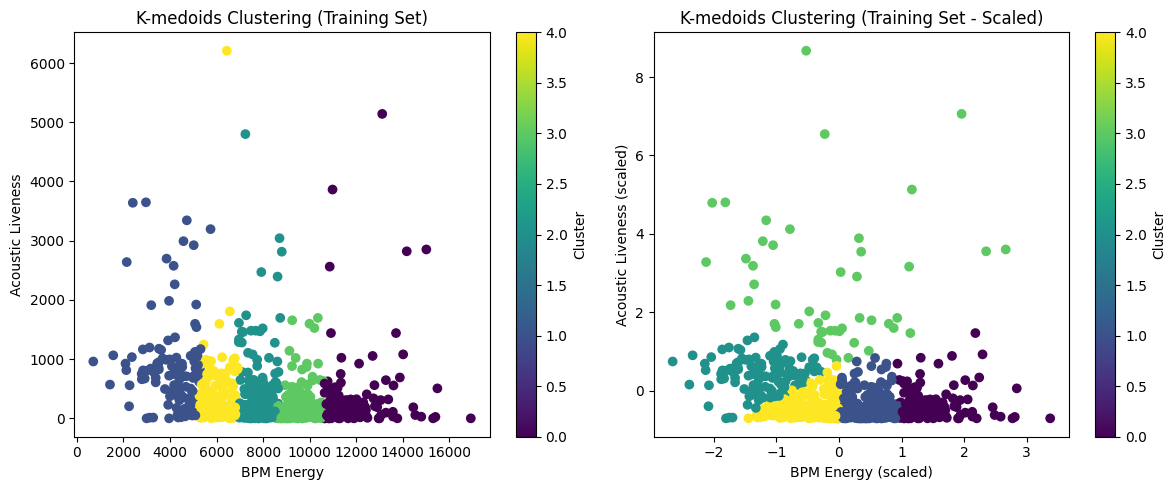

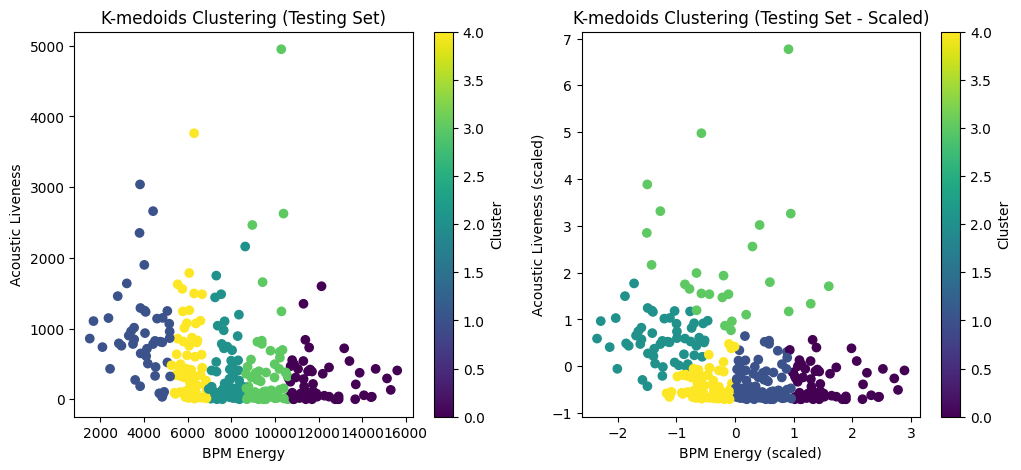

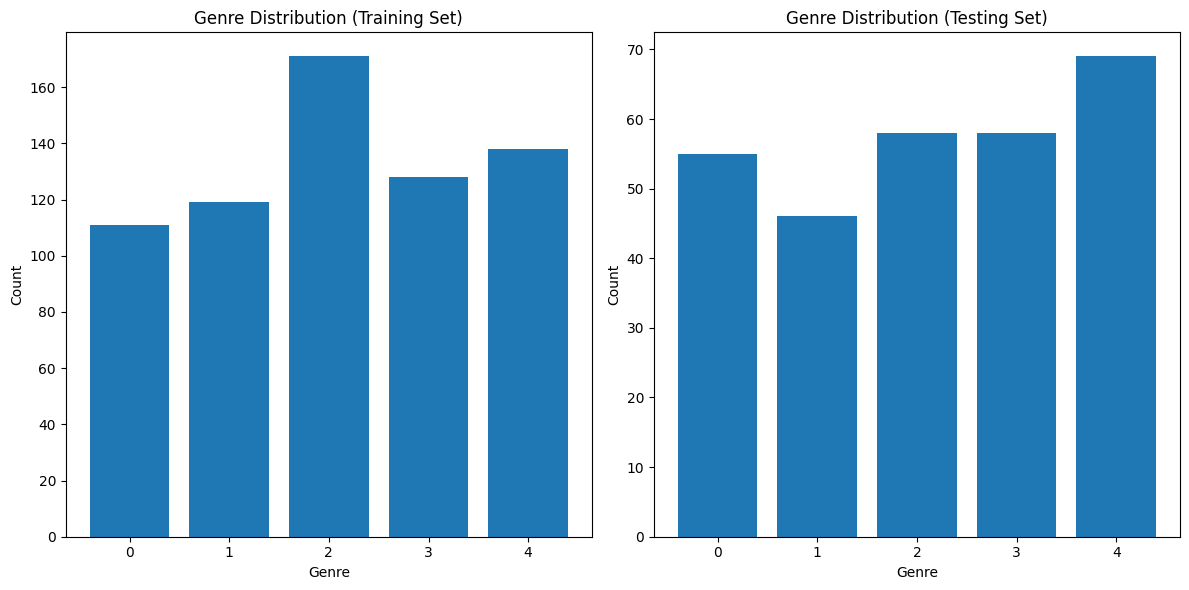

In [12]:
# Split the dataset into train and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Perform K-medoids clustering without scaling
kmedoids = KMedoids(n_clusters=5, random_state=42)
kmedoids.fit(X_train)

# Predict clusters for both training and testing sets
train_clusters = kmedoids.predict(X_train)
test_clusters = kmedoids.predict(X_test)

# Calculate silhouette scores without scaling
silhouette_train_before = silhouette_score(X_train, train_clusters, metric='euclidean')
silhouette_test_before = silhouette_score(X_test, test_clusters, metric='euclidean')
print('Silhouette Score before scaling (Training Set):', silhouette_train_before)
print('Silhouette Score before scaling (Testing Set):', silhouette_test_before)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform K-medoids clustering with scaling
kmedoids_scaled = KMedoids(n_clusters=5, random_state=42)
kmedoids_scaled.fit(X_train_scaled)

# Predict clusters for both training and testing sets after scaling
train_clusters_scaled = kmedoids_scaled.predict(X_train_scaled)
test_clusters_scaled = kmedoids_scaled.predict(X_test_scaled)

# Calculate silhouette scores after scaling
silhouette_train_after = silhouette_score(X_train_scaled, train_clusters_scaled, metric='euclidean')
silhouette_test_after = silhouette_score(X_test_scaled, test_clusters_scaled, metric='euclidean')
print('Silhouette Score after scaling (Training Set):', silhouette_train_after)
print('Silhouette Score after scaling (Testing Set):', silhouette_test_after)

# Visualization of clusters before scaling (Training Set)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train['bpm_energy'], X_train['acoustic_liveness'], c=train_clusters, cmap='viridis')
plt.title('K-medoids Clustering (Training Set)')
plt.xlabel('BPM Energy')
plt.ylabel('Acoustic Liveness')
plt.colorbar(label='Cluster')

# Visualization of clusters after scaling (Training Set)
plt.subplot(1, 2, 2)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_clusters_scaled, cmap='viridis')
plt.title('K-medoids Clustering (Training Set - Scaled)')
plt.xlabel('BPM Energy (scaled)')
plt.ylabel('Acoustic Liveness (scaled)')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Visualization of clusters before scaling (Testing Set)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test['bpm_energy'], X_test['acoustic_liveness'], c=test_clusters, cmap='viridis')
plt.title('K-medoids Clustering (Testing Set)')
plt.xlabel('BPM Energy')
plt.ylabel('Acoustic Liveness')
plt.colorbar(label='Cluster')

# Visualization of clusters after scaling (Testing Set)
plt.subplot(1, 2, 2)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_clusters_scaled, cmap='viridis')
plt.title('K-medoids Clustering (Testing Set - Scaled)')
plt.xlabel('BPM Energy (scaled)')
plt.ylabel('Acoustic Liveness (scaled)')
plt.colorbar(label='Cluster')

# Plot cluster distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Training Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Testing Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Performing Fuzzy C-Means Clustering

Silhouette Score before scaling (Training Set): 0.43693337732554544
Silhouette Score before scaling (Testing Set): 0.4435541599437195
Silhouette Score after scaling (Training Set): 0.36878507917024894
Silhouette Score after scaling (Testing Set): 0.38458856426414323


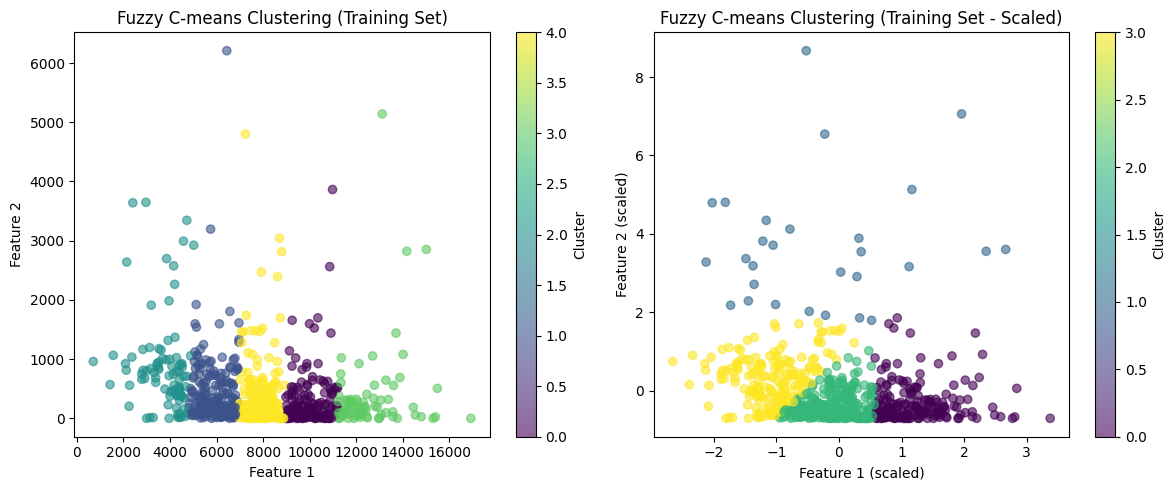

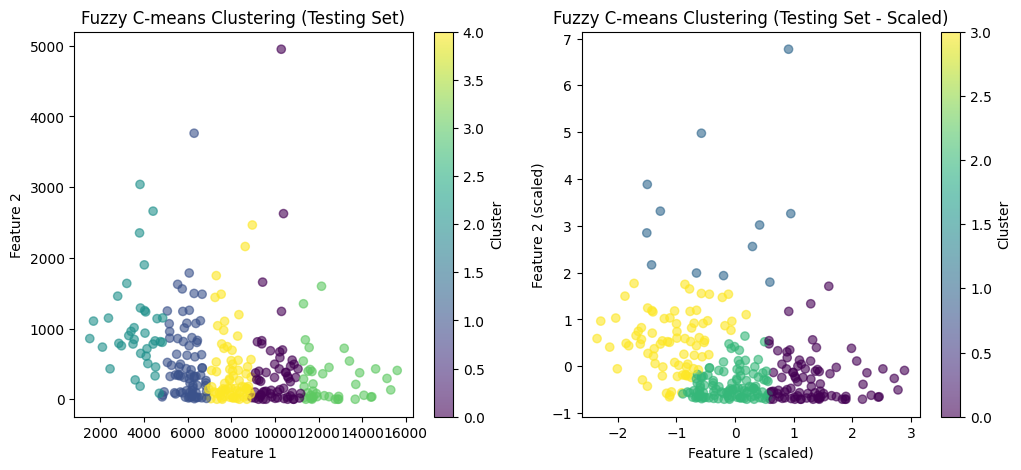

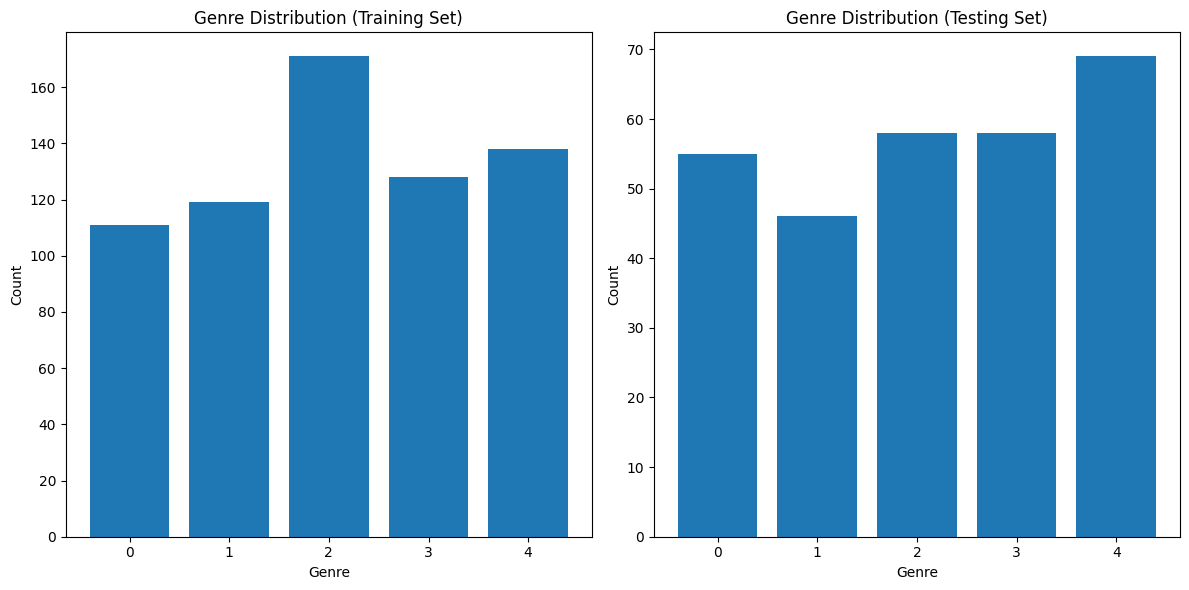

In [13]:
# Assuming X is your feature matrix and is properly defined
# Split the dataset into train and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Convert DataFrame to NumPy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

# Perform Fuzzy C-means clustering without scaling
fcm = FCM(n_clusters=5)
fcm.fit(X_train_np)  # Fit on NumPy array

# Predict fuzzy clusters for both training and testing sets
train_fuzzy_clusters = fcm.predict(X_train_np)
test_fuzzy_clusters = fcm.predict(X_test_np)

# Calculate silhouette scores without scaling
silhouette_train_before = silhouette_score(X_train_np, train_fuzzy_clusters, metric='euclidean')
silhouette_test_before = silhouette_score(X_test_np, test_fuzzy_clusters, metric='euclidean')
print('Silhouette Score before scaling (Training Set):', silhouette_train_before)
print('Silhouette Score before scaling (Testing Set):', silhouette_test_before)

# Perform Fuzzy C-means clustering with scaling
fcm_scaled = FCM(n_clusters=4)
fcm_scaled.fit(X_train_scaled)  # Fit on scaled NumPy array

# Predict fuzzy clusters for both training and testing sets after scaling
train_fuzzy_clusters_scaled = fcm_scaled.predict(X_train_scaled)
test_fuzzy_clusters_scaled = fcm_scaled.predict(X_test_scaled)

# Calculate silhouette scores after scaling
silhouette_train_after = silhouette_score(X_train_scaled, train_fuzzy_clusters_scaled, metric='euclidean')
silhouette_test_after = silhouette_score(X_test_scaled, test_fuzzy_clusters_scaled, metric='euclidean')
print('Silhouette Score after scaling (Training Set):', silhouette_train_after)
print('Silhouette Score after scaling (Testing Set):', silhouette_test_after)

# Visualizations (before and after scaling)
# Please replace 'Feature 1' and 'Feature 2' with actual feature names from your dataset
# Visualization of clusters before scaling (Training Set)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=train_fuzzy_clusters, cmap='viridis', alpha=0.6)
plt.title('Fuzzy C-means Clustering (Training Set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Visualization of clusters after scaling (Training Set)
plt.subplot(1, 2, 2)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_fuzzy_clusters_scaled, cmap='viridis', alpha=0.6)
plt.title('Fuzzy C-means Clustering (Training Set - Scaled)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Visualization of clusters before scaling (Testing Set)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=test_fuzzy_clusters, cmap='viridis', alpha=0.6)
plt.title('Fuzzy C-means Clustering (Testing Set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Visualization of clusters after scaling (Testing Set)
plt.subplot(1, 2, 2)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_fuzzy_clusters_scaled, cmap='viridis', alpha=0.6)
plt.title('Fuzzy C-means Clustering (Testing Set - Scaled)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Cluster')

# Plot cluster distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Training Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_clusters, bins=range(6), align='left', rwidth=0.8)
plt.title('Genre Distribution (Testing Set)')
plt.xlabel('Genre')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

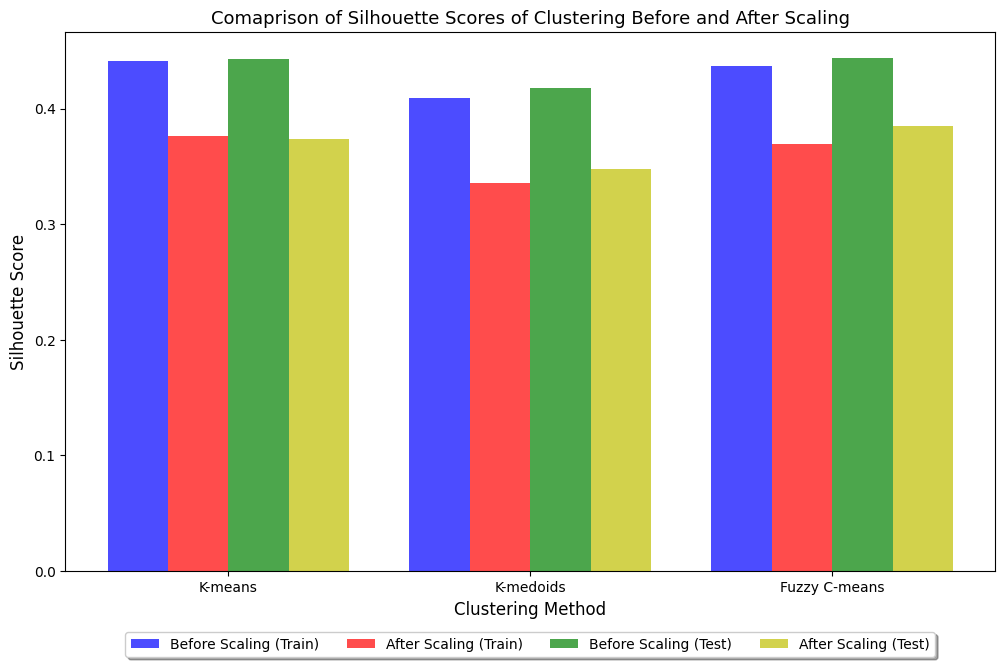

In [21]:
#K-means Performance
# Silhouette Score before scaling (Training Set): 0.44107408392573316
# Silhouette Score before scaling (Testing Set): 0.44331686629709105
# Silhouette Score after scaling (Training Set): 0.375697771352107
# Silhouette Score after scaling (Testing Set): 0.37360646888569843

#K-medoids Performance
# Silhouette Score before scaling (Training Set): 0.40924581460049075
# Silhouette Score before scaling (Testing Set): 0.4177995686990486
# Silhouette Score after scaling (Training Set): 0.3359186915767302
# Silhouette Score after scaling (Testing Set): 0.3479234846629301

#Fuzzy C-means Performance
# Silhouette Score before scaling (Training Set): 0.43693337732554544
# Silhouette Score before scaling (Testing Set): 0.4435541599437195
# Silhouette Score after scaling (Training Set): 0.36878507917024894
# Silhouette Score after scaling (Testing Set): 0.38458856426414323

# Define data for plotting
methods = ['K-means', 'K-medoids', 'Fuzzy C-means']
before_scaling_train = [0.441, 0.409, 0.437]
after_scaling_train = [0.376, 0.336, 0.369]
before_scaling_test = [0.443, 0.418, 0.444]
after_scaling_test = [0.374, 0.348, 0.385]

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))  # Increase figure size
bar_width = 0.2
index = range(len(methods))

# Plot bars with appropriate spacing
rects1 = ax.bar(index, before_scaling_train, bar_width, label='Before Scaling (Train)', color='b', alpha=0.7)
rects2 = ax.bar([p + bar_width for p in index], after_scaling_train, bar_width, label='After Scaling (Train)', color='r', alpha=0.7)
rects3 = ax.bar([p + 2*bar_width for p in index], before_scaling_test, bar_width, label='Before Scaling (Test)', color='g', alpha=0.7)
rects4 = ax.bar([p + 3*bar_width for p in index], after_scaling_test, bar_width, label='After Scaling (Test)', color='y', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Clustering Method', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Comaprison of Silhouette Scores of Clustering Before and After Scaling', fontsize=13)
ax.set_xticks([p + 1.5*bar_width for p in index])
ax.set_xticklabels(methods, fontsize=10)

# Place legend outside the plot area to avoid overlapping with bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=4, fontsize='medium')

# Show plot
plt.show()
